In [1]:
!pip install transformers
!wget -nc http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip

     |████████████████████████████████| 675kB 8.5MB/s 
     |████████████████████████████████| 1.1MB 43.4MB/s 
     |████████████████████████████████| 3.8MB 29.2MB/s 
     |████████████████████████████████| 890kB 62.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=e434a04f42fbc6602c5afde2ac61640c3501d438028fed65c27dd6080ba49d68
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
--2020-06-29 01:13:35--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2020-06-29 01:13:36--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.s

In [2]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
import torch
import html
import re
from torch import nn, optim
import seaborn as sns
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None, names=['polarity','id','date','query','user','tweet'], encoding='latin-1')

In [4]:
df.head()

,polarity,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
def update_polarity(polarity):
  if polarity==0:
    return 0
  else:
    return 1

In [7]:
def preprocess_tweet(text):
  # remove HTML tags
  def remove_html_tags(sentence):
    sentence = html.unescape(sentence)
    sentence = sentence.replace("\\","")
    sentence = sentence.replace("\r"," ")
    sentence = sentence.replace("\n"," ")

    p = re.compile(r'\/\w+\/')
    sentence = re.sub(p,' ',sentence)

    p = re.compile('<.*?>')
    sentence= re.sub(p, ' ', str(sentence))

    sentence = re.sub(r'http\S+', '', sentence)
    return sentence
  
  text = remove_html_tags(text)

  #remove @ Instances
  p = re.compile('@.*?\s+')
  text = re.sub(p, '', text)

  return text


In [8]:
df['polarity'] = df.polarity.apply(update_polarity)
df['tweet'] = df.tweet.apply(preprocess_tweet)

In [9]:
# Sampling 70000 entries (resource constraints)
df=df.sample(100000)

[Text(0, 0, 'negative'), Text(0, 0, 'positive')]

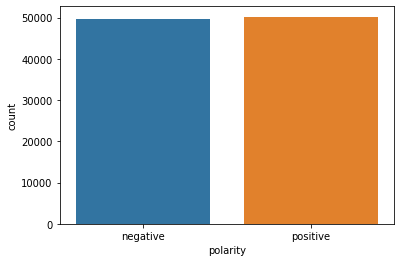

In [10]:
r = sns.countplot(df.polarity)
r.set_xticklabels(['negative','positive'])

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [12]:
token_length = []
for text in df.tweet:
  tokens = tokenizer.tokenize(text)
  token_length.append(len(tokens))

Text(0.5, 0, 'token count')

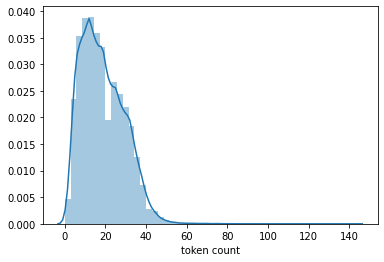

In [13]:
sns.distplot(token_length)
plt.xlabel('token count')

In [22]:
MAX_LEN = 60
BATCH_SIZE = 128
NUM_EPOCHS = 10
NUM_CLASSES = 2

In [15]:
class TweetDataset(Dataset):
  def __init__(self, tweet, polarity, tokenizer, max_seq_length):
    self.tweets = tweet
    self.polarities = polarity
    self.tokenizer = tokenizer
    self.max_seq_length = max_seq_length

  def __len__(self):
    return len(self.tweets) 

  def __getitem__(self, idx):
    tweet = self.tweets[idx]
    polarity = self.polarities[idx]

    enc = tokenizer.encode_plus(tweet, add_special_tokens=True, max_length=self.max_seq_length, return_token_type_ids=False, return_attention_mask=True, 
                                      pad_to_max_length=True,return_tensors='pt')
    return {
        'input_ids': enc['input_ids'].flatten(),
        'attention_mask': enc['attention_mask'].flatten(),
        'tweet': tweet,
        'polarity': torch.tensor(polarity, dtype=torch.long)
    }


In [17]:
df_train, df_val = train_test_split(df, test_size=0.2)
df_val, df_test = train_test_split(df_val, test_size=0.5)

In [18]:
def create_data_loader(df, tokenizer, max_length, batch_size):
  dataset = TweetDataset(df.tweet.to_numpy(), df.polarity.to_numpy(), tokenizer, MAX_LEN)
  return DataLoader(dataset, batch_size=batch_size, num_workers=4)


In [19]:
train_dataloader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
# Create Sentiment Classifier
bert_model = BertModel.from_pretrained('bert-base-cased')

In [21]:
bert_model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

In [24]:
class TweetClassifier(nn.Module):
  def __init__(self, model):
    super(TweetClassifier, self).__init__()
    self.model = model
    self.dropout = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.model.config.hidden_size, NUM_CLASSES)

  def forward(self, input_id, attention_mask):
    hidden_state, pool_output = self.model(input_ids = input_id, attention_mask=attention_mask)
    dropout_out = self.dropout(pool_output)
    out = self.linear(dropout_out) 
    
    return out


In [25]:
model = TweetClassifier(bert_model)
device = torch.device("cuda: 0" if torch.cuda.is_available else "cpu")
model.to(device)

TweetClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [30]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [31]:
next(iter(train_dataloader)).keys()

dict_keys(['input_ids', 'attention_mask', 'tweet', 'polarity'])

In [32]:
def train(model, dataloader, loss_fn, scheduler, optimizer, num_examples, device ):
  model = model.train()
  total_loss = 0
  correct_predictions = 0
  for data in dataloader:
    input_ids, attention_mask, polarity = data['input_ids'].to(device), data['attention_mask'].to(device), data['polarity'].to(device)
    outputs = model(input_ids, attention_mask)
    _, preds = torch.max(outputs, dim=1)
    
    loss = loss_fn(outputs, polarity)
    correct_predictions += torch.sum(preds == polarity).double()/len(preds)
    
    total_loss += loss

    loss.backward()
    # print ("cur loss: ", loss)
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/num_examples, total_loss.double()/num_examples

In [33]:
def eval(model, dataloader, loss_fn, num_examples, device):
  model = model.eval()
  total_loss = 0
  correct_predictions = 0
  with torch.no_grad():
    for data in dataloader:
      input_ids, attention_mask, polarity = data['input_ids'].to(device), data['attention_mask'].to(device), data['polarity'].to(device)
      outputs = model(input_ids, attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, polarity)
      correct_predictions += torch.sum(preds == polarity).double()/len(preds)
      total_loss += loss
  return correct_predictions.double()/num_examples, total_loss.double()/num_examples

In [34]:
# Training
history = defaultdict(list)
best_acc = 0
for ep in range(NUM_EPOCHS):
  train_acc, train_loss = train(model, train_dataloader, loss_fn, scheduler, optimizer, len(train_dataloader), device)
  print ("Epoch: ", ep)
  print ("Training Accuracy: %s, Training Loss: %s" % (train_acc, train_loss))

  val_acc, val_loss = eval(model, val_dataloader, loss_fn, len(val_dataloader), device)
  print ("Validation Accuracy: %s, Validation Loss: %s" % (val_acc, val_loss))

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  
  if val_acc >  best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), 'best_model.bin')

Epoch:  0
Training Accuracy: tensor(0.8147, device='cuda:0', dtype=torch.float64), Training Loss: tensor(0.4087, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Validation Accuracy: tensor(0.8470, device='cuda:0', dtype=torch.float64), Validation Loss: tensor(0.3528, device='cuda:0', dtype=torch.float64)
Epoch:  1
Training Accuracy: tensor(0.8869, device='cuda:0', dtype=torch.float64), Training Loss: tensor(0.2750, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Validation Accuracy: tensor(0.8422, device='cuda:0', dtype=torch.float64), Validation Loss: tensor(0.3705, device='cuda:0', dtype=torch.float64)
Epoch:  2
Training Accuracy: tensor(0.9286, device='cuda:0', dtype=torch.float64), Training Loss: tensor(0.1860, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Validation Accuracy: tensor(0.8378, device='cuda:0', dtype=torch.float64), Validation Loss: tensor(0.4304, device='cuda:0', dtype=torch.float64)
Epoch:  3
Training Accuracy: tensor(0.95

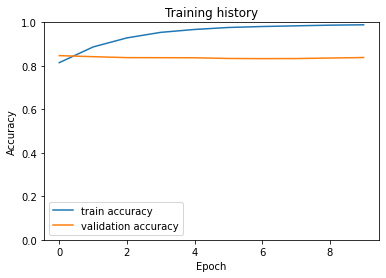

In [35]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [36]:
# Test Set Evaluation
model.load_state_dict(torch.load('best_model.bin'))
model = model.to(device)

test_acc, test_loss = eval(model, test_dataloader, loss_fn, len(test_dataloader), device)
print ("Test accuracy is: ", test_acc.item())

Test accuracy is:  0.831190664556962


In [37]:
def generate_predictions(model, dataloader):
  model = model.eval()
  tweets = []
  gold_value = []
  predicted_value = []
  with torch.no_grad():
    for data in dataloader:
      input_ids, attention_mask, polarity, tweet = data['input_ids'].to(device), data['attention_mask'].to(device), data['polarity'].to(device), data['tweet']
      outputs = model(input_ids, attention_mask)
      _, preds = torch.max(outputs, dim=1)

      tweets.extend(tweet)
      gold_value.extend(polarity)
      predicted_value.extend(preds)
      
  gold_value = torch.stack(gold_value).cpu()
  predicted_value = torch.stack(predicted_value).cpu()

  return tweets, gold_value, predicted_value

In [38]:
tweets, y_gold, y_pred = generate_predictions(model, test_dataloader)

In [39]:
print (classification_report(y_gold, y_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.82      0.85      0.83      4951
    positive       0.85      0.81      0.83      5049

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



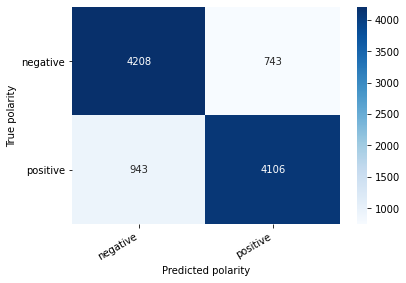

In [40]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True polarity')
  plt.xlabel('Predicted polarity');
cm = confusion_matrix(y_gold, y_pred)
df_cm = pd.DataFrame(cm, index=['negative','positive'], columns=['negative','positive'])
show_confusion_matrix(df_cm)

In [41]:
test_tweet = "Great survey of the state-of-the-art language models https://medium.com/@phylypo/a-survey-of-the-state-of-the-art-language-models-up-to-early-2020-aba824302c6 #NLProc"

In [42]:
tweet = preprocess_tweet(test_tweet)

In [43]:
encoded_tweet = tokenizer.encode_plus(tweet, add_special_tokens=True, max_length=MAX_LEN, return_token_type_ids=False, return_attention_mask=True, 
                                      pad_to_max_length=True,return_tensors='pt')


In [44]:
input_ids, attention_mask = encoded_tweet['input_ids'].to(device), encoded_tweet['attention_mask'].to(device)
outputs = model(input_ids, attention_mask)
_, preds = torch.max(outputs, dim=1)

In [45]:
polarities = ['negative','positive']
print("User Tweet: ", test_tweet)
print ("Predicted polarity: ", polarities[preds])

User Tweet:  Great survey of the state-of-the-art language models https://medium.com/@phylypo/a-survey-of-the-state-of-the-art-language-models-up-to-early-2020-aba824302c6 #NLProc
Predicted polarity:  positive
